In [1]:

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv("diabetic_data.csv")
icd = pd.read_csv("ccs_multi_dx_tool_2015.csv")
icd["ICD"] = icd["'ICD-9-CM CODE'"].apply(lambda x: x.replace("'",""))
icd["CAT"] = icd["'CCS LVL 1'"].apply(lambda x: x.replace("'",""))

In [12]:
icd.head()

,'ICD-9-CM CODE','CCS LVL 1','CCS LVL 1 LABEL','CCS LVL 2','CCS LVL 2 LABEL','CCS LVL 3','CCS LVL 3 LABEL','CCS LVL 4','CCS LVL 4 LABEL',ICD,CAT
0,'01000','1',Infectious and parasitic diseases,'1.1',Bacterial infection,'1.1.1',Tuberculosis [1.],' ',,01000,1
1,'01001','1',Infectious and parasitic diseases,'1.1',Bacterial infection,'1.1.1',Tuberculosis [1.],' ',,01001,1
2,'01002','1',Infectious and parasitic diseases,'1.1',Bacterial infection,'1.1.1',Tuberculosis [1.],' ',,01002,1
3,'01003','1',Infectious and parasitic diseases,'1.1',Bacterial infection,'1.1.1',Tuberculosis [1.],' ',,01003,1
4,'01004','1',Infectious and parasitic diseases,'1.1',Bacterial infection,'1.1.1',Tuberculosis [1.],' ',,01004,1


In [13]:
df.head(20)

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
5,35754,82637451,Caucasian,Male,[50-60),?,2,1,2,3,?,?,31,6,16,0,0,0,414,411,250,9,None,None,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Yes,>30
6,55842,84259809,Caucasian,Male,[60-70),?,3,1,2,4,?,?,70,1,21,0,0,0,414,411,V45,7,None,None,Steady,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
7,63768,114882984,Caucasian,Male,[70-80),?,1,1,7,5,?,?,73,0,12,0,0,0,428,492,250,8,None,None,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,>30
8,12522,48330783,Caucasian,Female,[80-90),?,2,1,4,13,?,?,68,2,28,0,0,0,398,427,38,8,None,None,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO
9,15738,63555939,Caucasian,Female,[90-100),?,3,3,4,12,?,InternalMedicine,33,3,18,0,0,0,434,198,486,8,None,None,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [10]:
df["gender"].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

<AxesSubplot:>

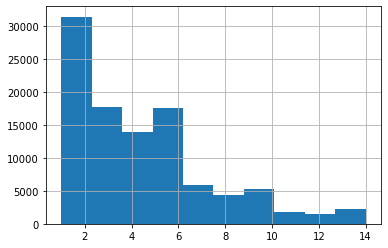

In [14]:
df["weight"].value_counts()

?            98569
[75-100)      1336
[50-75)        897
[100-125)      625
[125-150)      145
[25-50)         97
[0-25)          48
[150-175)       35
[175-200)       11
>200             3
Name: weight, dtype: int64

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

# EDA

Text(0.5, 1.0, 'Discharge Disposition')

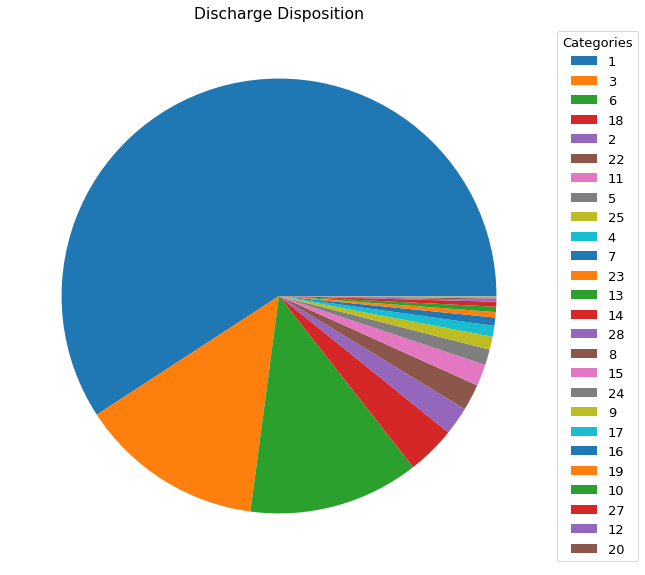

In [189]:
cats = df["discharge_disposition_id"]
#map(lambda x: x if pd.notnull(x) else "Other")
cats = cats.value_counts()

fig1, ax1 = plt.subplots(figsize=(10,10))

wedges, texts = ax1.pie(cats, 
        #autopct = lambda x: int(np.round(x/100.*sum(cats), 0)),
        textprops=dict(color="w"))

ax1.legend(wedges, cats.index,
          title="Categories",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=15, weight="bold")
plt.title("Discharge Disposition")

Text(0.5, 0, 'Age group')

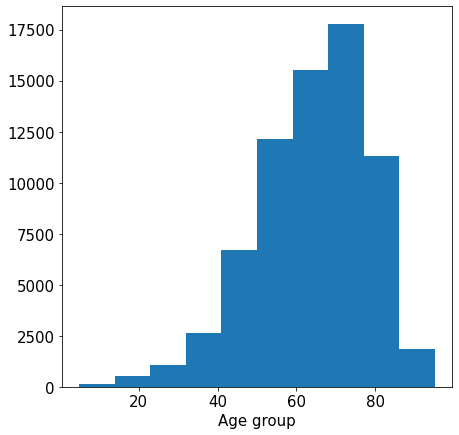

In [175]:
fig, ax = plt.subplots(figsize=(7,7))
plt.rcParams.update({'font.size': 15})
ax.hist(dfcleaned["age"])
plt.xlabel("Age group")


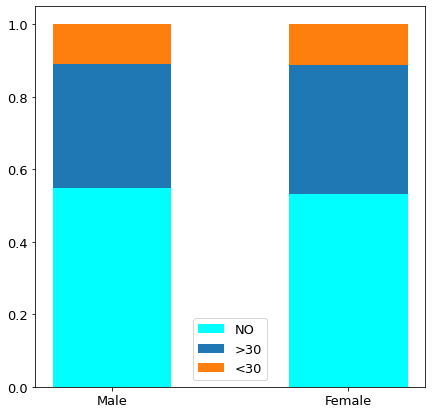

In [181]:
fig, ax = plt.subplots(figsize=(7,7))
nos = [len(df.loc[(df["gender"]==label)&(df["readmitted"]=="NO"), :])
         for label in ["Male", "Female"]]

bigs = [len(df.loc[(df["gender"]==label)&(df["readmitted"]==">30"), :])
         for label in ["Male", "Female"]]

smalls = [len(df.loc[(df["gender"]==label)&(df["readmitted"]=="<30"), :])
         for label in ["Male", "Female"]]

total0 = nos[0]+bigs[0]+smalls[0]
total1 = nos[1]+bigs[1]+smalls[1]
nos[0] = nos[0]/total0
bigs[0] = bigs[0]/total0
smalls[0] = smalls[0]/total0
nos[1] = nos[1]/total1
bigs[1] = bigs[1]/total1
smalls[1] = smalls[1]/total1

plt.rcParams.update({'font.size': 13})
x=np.arange(2)

barWidth = 0.5
ax.bar(["Male", "Female"], nos, color='cyan', label="NO", width = barWidth)
ax.bar(["Male", "Female"], bigs, bottom = nos, label=">30", width = barWidth)
ax.bar(["Male", "Female"], smalls, bottom = [i+j for i,j in zip(nos, bigs)], label="<30", width = barWidth)


plt.legend()

# value counts

# all kinds of med

In [41]:
for i in range(24, 47):
    print(df[df.columns[i]].value_counts())
    print()

No        81778
Steady    18346
Up         1067
Down        575
Name: metformin, dtype: int64

No        100227
Steady      1384
Up           110
Down          45
Name: repaglinide, dtype: int64

No        101063
Steady       668
Up            24
Down          11
Name: nateglinide, dtype: int64

No        101680
Steady        79
Up             6
Down           1
Name: chlorpropamide, dtype: int64

No        96575
Steady     4670
Up          327
Down        194
Name: glimepiride, dtype: int64

No        101765
Steady         1
Name: acetohexamide, dtype: int64

No        89080
Steady    11356
Up          770
Down        560
Name: glipizide, dtype: int64

No        91116
Steady     9274
Up          812
Down        564
Name: glyburide, dtype: int64

No        101743
Steady        23
Name: tolbutamide, dtype: int64

No        94438
Steady     6976
Up          234
Down        118
Name: pioglitazone, dtype: int64

No        95401
Steady     6100
Up          178
Down         87
Name: rosiglit

In [26]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

# Data cleaning

- drop weight
- gender
- drop payercode
- medical specialty
- examide, citoglipton
- admission_type_id, discharge_disposition_id, admission_source_id

columns that still have "missing" values:
- A1c
- Glucose
- race
- 

In [78]:
def mydrop(dfcleaned):
    #drop these columns
    dfcleaned = dfcleaned.drop(["weight", "payer_code","medical_specialty", "diag_2","diag_3","encounter_id"], axis=1)
    
    #two medicines with no dosage at all
    dfcleaned = dfcleaned.drop(["examide","citoglipton"], axis=1)
    
    #drop if gender unknown
    dfcleaned = dfcleaned[dfcleaned["gender"] != "Unknown/Invalid"]

    #drop if gender unknown
    dfcleaned = dfcleaned[dfcleaned["race"] != "?"]
    
    #drop if icd unknown
    dfcleaned = dfcleaned[dfcleaned["diag_1"] != "?"]
    
    #drop multiple patient records
    dfcleaned = dfcleaned.drop_duplicates(subset= ['patient_nbr'], keep = 'first')

    #drop patient_nbr
    dfcleaned = dfcleaned.drop(["patient_nbr"], axis=1)
    
    return dfcleaned

def icd_transform(dfcleaned):
    def icd_trans(code):
        code = code.replace(".","")
        part = icd[icd["ICD"].apply(lambda x: x.startswith(code))]
        res = part["CAT"].iloc[0]
        return res
    dfcleaned["diag"] = dfcleaned["diag_1"].apply(icd_trans)
    dfcleaned = dfcleaned.drop(["diag_1"],axis=1)
    return dfcleaned
    

def collapse(df):
    df['admission_type_id'] = df['admission_type_id'].replace(2,1)
    df['admission_type_id'] = df['admission_type_id'].replace(7,1)
    df['admission_type_id'] = df['admission_type_id'].replace(6,5)
    df['admission_type_id'] = df['admission_type_id'].replace(8,5)

    ####
    # discharge
    ####
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(6,8)
    
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(25, 18)
    
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(23, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(4, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(5, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(2, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(9, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(10, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(22, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(27, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(28, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(15, 3)
    
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24, 3)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(24, 3)

    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(28, 15)
    df['discharge_disposition_id'] = df['discharge_disposition_id'].replace(27, 15)
    
    ###
    # admission source
    ###
    df['admission_source_id'] = df['admission_source_id'].replace(23, 13)
    df['admission_source_id'] = df['admission_source_id'].replace(24, 13)
    df['admission_source_id'] = df['admission_source_id'].replace(11, 13)
    df['admission_source_id'] = df['admission_source_id'].replace(12, 13)
    
    df['admission_source_id'] = df['admission_source_id'].replace(10, 4)
    df['admission_source_id'] = df['admission_source_id'].replace(22, 4)
    df['admission_source_id'] = df['admission_source_id'].replace(25, 4)
    
    df['admission_source_id'] = df['admission_source_id'].replace(5, 6)
    
    df['admission_source_id'] = df['admission_source_id'].replace(2, 1)
    df['admission_source_id'] = df['admission_source_id'].replace(3, 1)
    
    df['admission_source_id'] = df['admission_source_id'].replace(9, 20)
    df['admission_source_id'] = df['admission_source_id'].replace(17, 20)    
                                        
    

In [79]:
def agemap(df):

    # convert age categories to mid-point values
    age_dict = {"[0-10)":5, "[10-20)":15, "[20-30)":25, "[30-40)":35, "[40-50)":45, 
                "[50-60)":55, "[60-70)":65, "[70-80)":75, "[80-90)":85, "[90-100)":95}
    df['age'] = df.age.map(age_dict)

In [80]:
## data cleaning


dfcleaned = df.copy()
dfcleaned = mydrop(dfcleaned)
dfcleaned = icd_transform(dfcleaned)
collapse(dfcleaned)
agemap(dfcleaned)



#dfcleaned.to_csv("dfcleaned_full.csv",index=False)

In [81]:
dfcleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69658 entries, 0 to 101765
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      69658 non-null  object
 1   gender                    69658 non-null  object
 2   age                       69658 non-null  int64 
 3   admission_type_id         69658 non-null  int64 
 4   discharge_disposition_id  69658 non-null  int64 
 5   admission_source_id       69658 non-null  int64 
 6   time_in_hospital          69658 non-null  int64 
 7   num_lab_procedures        69658 non-null  int64 
 8   num_procedures            69658 non-null  int64 
 9   num_medications           69658 non-null  int64 
 10  number_outpatient         69658 non-null  int64 
 11  number_emergency          69658 non-null  int64 
 12  number_inpatient          69658 non-null  int64 
 13  number_diagnoses          69658 non-null  int64 
 14  max_glu_serum        

In [83]:
dfcleaned_reduced = dfcleaned.copy()
dfcleaned_reduced = dfcleaned_reduced.loc[dfcleaned_reduced["discharge_disposition_id"] != 18,:]
dfcleaned_reduced = dfcleaned_reduced.loc[dfcleaned_reduced["admission_source_id"] != 9,:]
dfcleaned_reduced = dfcleaned_reduced.loc[ dfcleaned_reduced["admission_type_id"] != 5,:]


In [196]:
dfcleaned_reduced["readmitted"].value_counts()

NO     35283
>30    18099
<30     5119
Name: readmitted, dtype: int64

In [195]:
dfcleaned_reduced["discharge_disposition_id"].value_counts()

1     45481
3      9568
2      1766
11      934
14      398
7       354
Name: discharge_disposition_id, dtype: int64

In [88]:
dfcleaned_reduced.to_csv("dfcleaned_reduced.csv",index=False)

<BarContainer object of 2 artists>

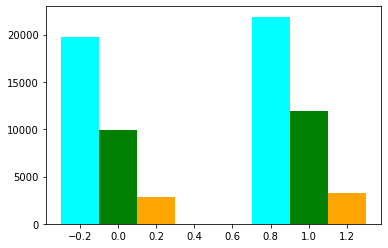

In [25]:
nos = [len(dfcleaned.loc[(dfcleaned["gender"]==label)&(dfcleaned["readmitted"]=="NO"), :])
         for label in ["Male", "Female"]]

bigs = [len(dfcleaned.loc[(dfcleaned["gender"]==label)&(dfcleaned["readmitted"]==">30"), :])
         for label in ["Male", "Female"]]

smalls = [len(dfcleaned.loc[(dfcleaned["gender"]==label)&(dfcleaned["readmitted"]=="<30"), :])
         for label in ["Male", "Female"]]


x=np.arange(2)
plt.bar(x-0.2, nos, 0.2, color='cyan')
plt.bar(x, bigs, 0.2, color='green')
plt.bar(x+0.2, smalls, 0.2, color='orange')

(array([2.1522e+04, 2.3000e+02, 4.3000e+01, 2.2000e+01, 5.0000e+00,
        5.0000e+00, 3.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <BarContainer object of 10 artists>)

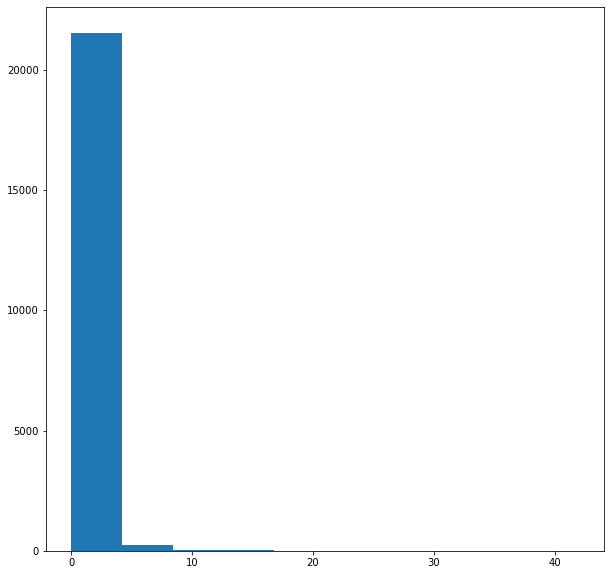

In [34]:
fig, ax = plt.subplots(figsize=(10,10))
ax.hist(dfcleaned[dfcleaned["readmitted"]==">30"]["number_outpatient"])

# Further cleaning (med treatments)

## insulin processing (and metformin )

In [90]:
meds = dfcleaned_reduced.columns[16:37]
meds

Index(['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone'],
      dtype='object')

In [89]:
dfcleaned_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58501 entries, 1 to 101765
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   race                      58501 non-null  object
 1   gender                    58501 non-null  object
 2   age                       58501 non-null  int64 
 3   admission_type_id         58501 non-null  int64 
 4   discharge_disposition_id  58501 non-null  int64 
 5   admission_source_id       58501 non-null  int64 
 6   time_in_hospital          58501 non-null  int64 
 7   num_lab_procedures        58501 non-null  int64 
 8   num_procedures            58501 non-null  int64 
 9   num_medications           58501 non-null  int64 
 10  number_outpatient         58501 non-null  int64 
 11  number_emergency          58501 non-null  int64 
 12  number_inpatient          58501 non-null  int64 
 13  number_diagnoses          58501 non-null  int64 
 14  max_glu_serum        

In [91]:
# taking out insulin and store in df

dfcleaned_insulin = dfcleaned_reduced[list(dfcleaned_reduced.columns.difference(meds))]
dfcleaned_insulin.loc[:,"insulin"] = dfcleaned_reduced.loc[:,"insulin"]

dfcleaned_insulin.to_csv("dfcleaned_insulin.csv", index=False)

/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [95]:
# taking out metformin and store in df

dfcleaned_metformin = dfcleaned_reduced[list(dfcleaned_reduced.columns.difference(meds))]
dfcleaned_metformin.loc[:,"metformin"] = dfcleaned_reduced.loc[:,"metformin"]

dfcleaned_metformin.to_csv("dfcleaned_metformin.csv", index=False)

/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/yuepengwang/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


## insulin metform combo processing

In [96]:
combo = dfcleaned_reduced.apply(lambda x: "(" + x["insulin"] + "," + x["metformin"] + ")", axis=1)
dfcleaned_insulin_metformin = dfcleaned_reduced.copy()
dfcleaned_insulin_metformin.loc[:,"insulin_metformin_combo"] = combo
dfcleaned_insulin_metformin = dfcleaned_insulin_metformin[list(dfcleaned_insulin_metformin.columns.difference(meds))]
dfcleaned_insulin_metformin.to_csv("dfcleaned_insulin_metformin.csv", index=False)

In [100]:
dfcleaned_insulin_metformin["insulin_metformin_combo"].value_counts()

(No,No)            21676
(Steady,No)        14605
(No,Steady)         5685
(Down,No)           5291
(Up,No)             4559
(Steady,Steady)     3640
(Up,Steady)         1024
(Down,Steady)        996
(No,Up)              259
(Steady,Up)          241
(No,Down)            141
(Steady,Down)        132
(Up,Up)               91
(Down,Up)             84
(Down,Down)           46
(Up,Down)             31
Name: insulin_metformin_combo, dtype: int64

In [200]:
dfcleaned_insulin_metformin[dfcleaned_insulin_metformin["insulin_metformin_combo"]
                            == "(Up,Down)" ]["readmitted"].value_counts()


>30    16
NO     13
<30     2
Name: readmitted, dtype: int64

In [104]:
groups = ["(No,No)","(Steady,No)","(No,Steady)","(Down,No)","(Up,No)","(Steady,Steady)"]
dfcleaned_insulin_metformin_agg = dfcleaned_insulin_metformin.copy()
res = dfcleaned_insulin_metformin_agg.loc[:,"insulin_metformin_combo"].apply(lambda x:
                                                                      x if x in groups else "Other")
dfcleaned_insulin_metformin_agg.loc[:,"insulin_metformin_combo"] = res


In [106]:
dfcleaned_insulin_metformin_agg.to_csv("dfcleaned_insulin_metformin_agg.csv", index=False)

# Testing

In [125]:
df_insulin = pd.read_csv("dfcleaned_insulin.csv")

In [128]:
icd[icd["CAT"] == "2"].iloc[1,:]["'CCS LVL 1 LABEL'"]

'Neoplasms'

In [129]:
for i in range(1,19):
    print(i, icd[icd["CAT"] == str(i)].iloc[1,:]["'CCS LVL 1 LABEL'"])

1 Infectious and parasitic diseases
2 Neoplasms
3 Endocrine; nutritional; and metabolic diseases and immunity disorders
4 Diseases of the blood and blood-forming organs
5 Mental Illness
6 Diseases of the nervous system and sense organs
7 Diseases of the circulatory system
8 Diseases of the respiratory system
9 Diseases of the digestive system
10 Diseases of the genitourinary system
11 Complications of pregnancy; childbirth; and the puerperium
12 Diseases of the skin and subcutaneous tissue
13 Diseases of the musculoskeletal system and connective tissue
14 Congenital anomalies
15 Certain conditions originating in the perinatal period
16 Injury and poisoning
17 Symptoms; signs; and ill-defined conditions and factors influencing health status
18 Residual codes; unclassified; all E codes [259. and 260.]
